In [1]:
cd ..

/home/amit/Practice/test


In [2]:
%run lib/__init__.py
%matplotlib inline

# Semantic Search

## Latent Semantic search - model development



## Load articles from 'pagestest' collection MongoDB and create ' corpus ' for search engine

In [3]:
myWiki=MyWikiDB()

In [4]:
cat_loaded_cllr=myWiki.dbr.loads_collection

In [5]:
#Load history - check which categories loaded 
cursor=cat_loaded_cllr.find()
loaded=list(cursor)
pd.DataFrame(loaded)

,_id,loaded,master_cat,sub_cats_added
0,5ae630f2023fe316d2ab7e88,Sun Apr 29 21:54:10 2018,Category:Classification algorithms,5


In [6]:
pagestest_cllr=myWiki.dbr.pagetest_collection

In [7]:
print('No. of pages loaded = {}'.format(pagestest_cllr.find().count()))

No. of pages loaded = 262


In [8]:
cursor=pagestest_cllr.find()
pages=list(cursor)

In [9]:
corpus_df=pd.DataFrame(pages[:1000])
corpus_df.head()

,_id,category_list,extract,ns,pageid,pull_category,title
0,32003319,[Category:Algorithms and data structures stubs...,approximate near neighbor search special case ...,0,32003319,Category:Classification algorithms,(1+ε)-approximate nearest neighbor search
1,740955,"[Category:Classification algorithms, Category:...",two main us term calibration statistic denote ...,0,740955,Category:Classification algorithms,Calibration (statistics)
2,843901,[Category:Classification algorithms],soft independent modelling class analogy simca...,0,843901,Category:Classification algorithms,Soft independent modelling of class analogies
3,1579244,[Category:All articles lacking in-text citatio...,machine learning statistic classification prob...,0,1579244,Category:Classification algorithms,Statistical classification
4,27156903,"[Category:Classification algorithms, Category:...",statistic adaptive variable bandwidth kernel d...,0,27156903,Category:Classification algorithms,Variable kernel density estimation


In [10]:
#Remove unnecessary columns
columns_to_drop=['ns', 'category_list','pull_category', '_id']
corpus_df.drop(columns_to_drop, axis=1, inplace=True)

In [11]:
corpus_df.set_index('title', inplace=True)

In [12]:
corpus_df.head()

,extract,pageid
title,,
(1+ε)-approximate nearest neighbor search,approximate near neighbor search special case ...,32003319
Calibration (statistics),two main us term calibration statistic denote ...,740955
Soft independent modelling of class analogies,soft independent modelling class analogy simca...,843901
Statistical classification,machine learning statistic classification prob...,1579244
Variable kernel density estimation,statistic adaptive variable bandwidth kernel d...,27156903


In [13]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, (1+ε)-approximate nearest neighbor search to Wolfram Language
Data columns (total 2 columns):
extract    262 non-null object
pageid     262 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.1+ KB


## Abreviations to use in code
* dtm = document term matrix
* dtma= augmented document term matrix - including search term
* sp = sparse as apposed to df = dataframe
* svdm= singular value decomposition matrix  - by component
* svdma= singular value decomposition augmented matrix  - including search term
* tfidf_v= TFiDF Vectorizer
* svd_v= svd vectorizer
* lsa= Latent Semantic Analysis
* sterm= search term

### Label encode the title

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline

In [15]:
le=LabelEncoder()
corpus_df['title_numerical'] = le.fit_transform(corpus_df.index)

In [16]:
corpus_df.head(4)

,extract,pageid,title_numerical
title,,,
(1+ε)-approximate nearest neighbor search,approximate near neighbor search special case ...,32003319,0
Calibration (statistics),two main us term calibration statistic denote ...,740955,32
Soft independent modelling of class analogies,soft independent modelling class analogy simca...,843901,230
Statistical classification,machine learning statistic classification prob...,1579244,233


### Prepare for Document Term Matrix (DTM)
Use TFIDF (Term Frequency x Inverse Document Frequency) to generate document term matrix.
 - Apply following hyperparatmeters, tests run with different values
     - remove 'english' stop words ( this was also done in cleaning proces but on testing resulting size of dtm TFIDF removes addtional stopwords.)
     - keep repeating groups of 1 to 2 words  (ngrams)  - tested with and without
     - set minimum no. of documents a term must occur in ( min_df ) - tested 1 or 2 

In [17]:
#test 3
tfidf_v = TfidfVectorizer(stop_words = 'english', min_df=1  )

In [18]:
%%time
dtm_sp = tfidf_v.fit_transform(corpus_df.extract)

CPU times: user 156 ms, sys: 7.96 ms, total: 164 ms
Wall time: 213 ms


In [19]:
dtm_sp

<262x9955 sparse matrix of type '<class 'numpy.float64'>'
	with 57306 stored elements in Compressed Sparse Row format>

In [20]:
dtm_df = pd.DataFrame(dtm_sp.toarray(),
                                       index=corpus_df.index,
                                       columns=tfidf_v.get_feature_names())

In [21]:
dtm_df.T.tail(10)

title,(1+ε)-approximate nearest neighbor search,Calibration (statistics),Soft independent modelling of class analogies,Statistical classification,Variable kernel density estimation,AdaBoost,ALOPEX,Alternating decision tree,Analogical modeling,Averaged one-dependence estimators,...,Neuro Laboratory,Neuroph,NeuroSolutions,OCRopus,Peltarion Synapse,Picas (app),Prisma (app),PSIPRED,SNNS,Wolfram Language
zoom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zquez,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zsa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ztemel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zucol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zufa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zupan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zwischen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
dtm_df.shape

(262, 9955)

### Compute SVD matrix

In [23]:
n_components = 200
svd_v = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [24]:
%%time
svdm = svd_v.fit_transform(dtm_df)

CPU times: user 3.65 s, sys: 225 ms, total: 3.88 s
Wall time: 1.39 s


In [25]:
sum(svd_v.explained_variance_ratio_)

0.90104749714479093

<Container object of 200 artists>

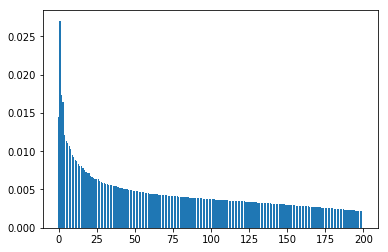

In [26]:
plt.bar(range(n_components), svd_v.explained_variance_ratio_)

In [27]:
lsa = pd.DataFrame(svdm,index=dtm_df.index,columns=component_names)
lsa['extract'] = corpus_df.extract
lsa['pageid'] = corpus_df.pageid

In [28]:
lsa.head(3)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_193,component_194,component_195,component_196,component_197,component_198,component_199,component_200,extract,pageid
title,,,,,,,,,,,,,,,,,,,,,
(1+ε)-approximate nearest neighbor search,0.104913,0.139973,-0.055479,-0.054447,-0.173937,-0.115522,-0.244504,0.417431,-0.176311,0.354236,...,0.010957,-0.088159,-0.045616,0.005960,-0.040667,0.037957,0.003156,-0.090397,approximate near neighbor search special case ...,32003319
Calibration (statistics),0.174065,0.159423,-0.036965,-0.088673,-0.028845,-0.123071,-0.057541,-0.177936,0.012291,-0.027207,...,0.047493,0.004612,-0.046441,0.038930,0.025171,0.022824,0.033867,0.013303,two main us term calibration statistic denote ...,740955
Soft independent modelling of class analogies,0.218589,0.192433,-0.055834,-0.134573,-0.105211,-0.081365,-0.126434,-0.097832,0.013654,-0.051383,...,0.007262,-0.023896,0.068188,-0.012114,0.038528,-0.008539,0.044502,0.031719,soft independent modelling class analogy simca...,843901


In [30]:
lsa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, (1+ε)-approximate nearest neighbor search to Wolfram Language
Columns: 202 entries, component_1 to pageid
dtypes: float64(200), int64(1), object(1)
memory usage: 425.5+ KB


In [31]:
comp_features = pd.DataFrame(svd_v.components_,index=component_names,columns=tfidf_v.get_feature_names()).T

### Look at feature breakdown of components
Lots of numbers, and symbols - need to remove

In [32]:
# Feature breakdown of componentes
top_20={}
for i in range(1,20):
    comp_features['abs_component_{}'.format(i)] = np.abs(comp_features['component_{}'.format(i)])

In [33]:
comp_features['abs_component_1'].sort_values(ascending=False).head(10)

network      0.326375
neural       0.219675
function     0.190006
use          0.170559
model        0.162842
neuron       0.161112
layer        0.156841
weight       0.139476
input        0.136284
algorithm    0.129710
Name: abs_component_1, dtype: float64

## Search process

1. input search term and vectorize using fitted TFIDF
2. Append search term to the DTM -> augmented DTM
3. SVD fit & transform on augemented DTM - > updated components
4. identify index for search term vector in svd matrix
5. Use cosine similarity to find most similar vectors in svd matrix

In [34]:
search_term='logistic regression'

In [35]:
s_term=[search_term]

#vectorize search term with TFIDF vectorizer (previously fitted)
s_term_encoded=tfidf_v.transform(s_term)
s_term_encoded_df = pd.DataFrame(s_term_encoded.toarray(), 
                                   index=['search_term'], 
                                   columns=tfidf_v.get_feature_names())

In [36]:
s_term_encoded_df

,aaai,aalto,aamodt,aargauer,aaron,ab,abandon,abb,abbreviate,abbreviation,...,zoom,zquez,zs,zsa,ztemel,zucol,zufa,zupan,zur,zwischen
search_term,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
dtma_df=()

In [38]:
%%time
#add to existing document term matrix
dtma_df=dtm_df.append(s_term_encoded_df)

CPU times: user 5.23 ms, sys: 81 µs, total: 5.32 ms
Wall time: 4.35 ms


In [39]:
dtma_df.shape

(263, 9955)

In [40]:
%%time
#re fit SVD to augmented document term matrix
component_names = ["component_"+str(i+1) for i in range(svd_v.n_components)]
svdma=svd_v.fit_transform(dtma_df)
svdma_df=pd.DataFrame(svdma,index=dtma_df.index,columns=component_names)

CPU times: user 2.81 s, sys: 111 ms, total: 2.92 s
Wall time: 762 ms


In [41]:
#find index of search term in refit SVD matrix
s_term_svd_vector=svdma_df.loc['search_term',:].values.reshape(1,-1)

In [42]:
#calculate cosine similarty of search term against other SVD vectors
svdma_df['cosine_sim'] = cosine_similarity(svdma_df, s_term_svd_vector)

In [43]:
print('top 10 wiki pages that are related to search term = {}'.format(s_term))
svdma_df[['cosine_sim']].sort_values('cosine_sim', ascending=False).head(10)
    

top 10 wiki pages that are related to search term = ['logistic regression']


,cosine_sim
search_term,1.000000
Logistic model tree,0.423865
Multinomial logistic regression,0.399734
Sigmoid function,0.373496
LogitBoost,0.260441
Softmax function,0.166457
Statistical classification,0.145457
Optimal discriminant analysis,0.133672
Calibration (statistics),0.124698
Rectifier (neural networks),0.115594
